<a href="https://colab.research.google.com/github/florian-frey/AudioSimilarity/blob/main/src/Classifier/CNNGenreClassifierASS3Spectrogramms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Genre Classifier based on Spectrograms of the FMA Dataset

# 1 Setup

## 1.1 Imports

In [1]:
!pip uninstall -q -y tensorflow
!pip install -q tensorflow==2.13

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 31.2 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
tf.__version__

'2.13.0'

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import math

import os
import re
import pandas as pd
import numpy as np
from PIL import Image
import librosa
import librosa.display
import matplotlib.pyplot as plt
import cv2
import warnings
warnings.filterwarnings('ignore')

## 1.2 Copy Data

In [4]:
# connect to google drive --> allows to store kaggle.json API token under the main folder in the drive,
#   so that it doesn't have to be uploaded every time
# Alternatively the kaggle.json can be uploaded under /content/

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
DATA_DIR = "/content/data_3sec/"
if not os.path.exists(DATA_DIR):
  shutil.unpack_archive("/content/drive/MyDrive/AllSpectrograms3Seconds.zip", DATA_DIR)

In [6]:
# DATA_DIR_STAGGED = "/content/data/"
# if not os.path.exists(DATA_DIR_STAGGED):
#   shutil.unpack_archive("/content/drive/MyDrive/spectrograms_stacked_v2.zip", DATA_DIR_STAGGED)

## 1.3 Prepare Dataset for Training

### 1.3.1 Optional: stack different spectrograms to one image

In [ ]:
# define path for stacked spectrograms
path_stacked_spectrograms = "/spectrograms_stacked/"

# create directorys
for sub_dir in ["traindata/", "testdata/", "valdata/"]:
  new_path = os.path.join(DATA_DIR, sub_dir, path_stacked_spectrograms)
  os.makedirs(new_path, exist_ok=True)

# # combine different spectrogram arrays into one
# for sub_dir in ["traindata/", "testdata/", "valdata/"]:
#   for
# # Define the regular expression pattern to match the numbers in the file name
# pattern = r"/(\d+)_.*(\d+)\.jpg$"

# # Extract the numbers using re.search() and group()
# match = re.search(pattern, path)

# if match:
#     first_number = match.group(1)
#     second_number = match.group(2)

In [ ]:
# test = np.array(Image.open("/content/data/testdata/chroma_stft/International/134941_chroma_stft0.jpg"))
# test2 = np.array(Image.open("/content/data/testdata/melspectrogram/International/134941_melspectrogram0.jpg"))
# test3 = np.array(Image.open("/content/data/traindata/spectral_contrast/Electronic/100497_spectral_contrast0.jpg"))

In [ ]:
# test = "100497_spectral_contrast1.jpg"
# pattern = r"(\d+)[a-z\_]+(\d+)\.jpg"
# match = re.findall(pattern, test)
# identifier1, identifier2 = match[0][0], match[0][1]
# identifier1, identifier2

In [ ]:
# Define the spectrogram folder names
spectrogram_folders = os.listdir(DATA_DIR+"testdata")      # ["chroma_stft", "melspectrogram", "spectral_contrast"]

# Define the subfolder names
subfolder_names = os.listdir(DATA_DIR+"testdata/chroma_stft")      # ["Electronic", "Blues", "Volk"]

# Initialize a dictionary to store images with the same identifiers
combined_images = {}

pattern = r"(\d+)[a-z\_]+(\d+)\.jpg"      # r"(\d+)_.*(\d+)\.jpg$"
missing_images = []

# Loop through each spectrogram folder and subfolder
for sub_dir in os.listdir(DATA_DIR):
  for spectrogram_folder in spectrogram_folders:
      for subfolder_name in subfolder_names:
          folder_path = os.path.join(DATA_DIR, sub_dir, spectrogram_folder, subfolder_name)

          # Loop through each image file in the subfolder
          for image_file in os.listdir(folder_path):
              if image_file.endswith(".jpg"):
                  # print(image_file)
                  # Extract the first and second identifiers from the image file name
                  # match = re.search(pattern, image_file)
                  # identifier1, identifier2 = match.group()[0], match.group()[1]
                  match = re.findall(pattern, image_file)
                  identifier1, identifier2 = match[0][0], match[0][1]
                  # Combine the spectrogram name and second identifier to create a unique key
                  key = f"{subfolder_name}_{identifier1}_{identifier2}"

                  # Open the image using PIL
                  image_path = os.path.join(folder_path, image_file)
                  image = Image.open(image_path)

                  # If the key already exists in the dictionary, concatenate the image horizontally

                  if np.array(image).shape[1] != 128:
                    missing_images.append(image_path)
                  else:
                    if key in combined_images:
                        combined_images[key] = np.vstack((combined_images[key], image))
                    else:
                        combined_images[key] = np.array(image)

# Convert the dictionary values (images) to a list
# combined_image_list = list(combined_images.values())

In [ ]:
len(combined_images), len(missing_images)

(142386, 22482)

In [ ]:
missing_in_dict = []
for key, value in combined_images.items():
  if len(value) != 147:
    missing_in_dict.append(key)
len(missing_in_dict)

0

In [ ]:
shutil.rmtree(path_stacked_spectrograms)

In [ ]:
path_stacked_spectrograms = "/content/spectrograms_stacked/"

# create directorys
for sub_dir in ["traindata/", "testdata/", "valdata/"]:
  for genre in subfolder_names:
    new_path = os.path.join(path_stacked_spectrograms, sub_dir, genre)
    os.makedirs(new_path, exist_ok=True)

In [ ]:
TRAIN_DIR = "/content/spectrograms_stacked/testdata"
TEST_DIR = "/content/spectrograms_stacked/traindata"
VAL_DIR = "/content/spectrograms_stacked/valdata"

In [ ]:
for key, value in combined_images.items():
  genre, identifier, id = key.split("_")
  if int(identifier) % 6 == 0:
    cv2.imwrite(f"{VAL_DIR}/{genre}/{identifier}_{id}.jpg", value)
  if int(identifier) % 6 == 1:
    cv2.imwrite(f"{TEST_DIR}/{genre}/{identifier}_{id}.jpg", value)
  else:
    cv2.imwrite(f"{TRAIN_DIR}/{genre}/{identifier}_{id}.jpg", value)

In [ ]:
output_dir = "/content/drive/MyDrive/spectrograms_stacked.zip"
shutil.make_archive(output_dir, "zip", path_stacked_spectrograms)

'/content/drive/MyDrive/spectrograms_stacked.zip.zip'

In [ ]:
del combined_images
import gc
gc.collect()

0

### 1.3.2 Setup and create dataset generators

In [11]:
# chose dataset
DATA_DIR = "/content/data_3sec/"   #  path_stacked_spectrograms
# SIC: train and testdata are changed due to previous naming error
TRAIN_DIR = DATA_DIR + "testdata/" + "melspectrogram/"
VAL_DIR = DATA_DIR + "valdata/" + "melspectrogram/"
TEST_DIR = DATA_DIR + "traindata/" + "melspectrogram/"

# configuration
# VAL_SIZE = 0.2    # only necessary, if dataset isn't already split
# TEST_SIZE = 0.2   # only necessary, if dataset isn't already split
IMG_HEIGHT = 147
IMG_WIDTH = 128
BATCH_SIZE = 32

# NUM_CHANNELS has to be 3 for "rgb" and 1 for "grayscale"
NUM_CHANNELS = 3

In [12]:
# load the training data set as rgb images
train_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_DIR,
  # validation_split=VAL_SIZE+TEST_SIZE,
  label_mode="categorical",
  # subset="training",
  # color_mode="grayscale",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

# load validation data set
val_ds = tf.keras.utils.image_dataset_from_directory(
  VAL_DIR,
  # validation_split=VAL_SIZE+TEST_SIZE,
  label_mode="categorical",
  # subset="validation",
  # color_mode="grayscale",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

# load test data set
test_ds = tf.keras.utils.image_dataset_from_directory(
  TEST_DIR,
  # validation_split=VAL_SIZE+TEST_SIZE,
  label_mode="categorical",
  # subset="validation",
  # color_mode="grayscale",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 23080 files belonging to 8 classes.
Found 23000 files belonging to 8 classes.
Found 103800 files belonging to 8 classes.


In [13]:
# store class names
CLASS_NAMES = train_ds.class_names
CLASS_NAMES

['Electronic',
 'Experimental',
 'Folk',
 'Hip-Hop',
 'Instrumental',
 'International',
 'Pop',
 'Rock']

In [14]:
# split validation data set in val_ds and test_ds
# val_batches = len(val_test_ds)
# test_ds = val_test_ds.take(val_batches // 2)
# val_ds = val_test_ds.skip(val_batches // 2)

# count number of batches in training, validation and test dataset
print(f"""The dataset is distributed in :
  - {len(train_ds)} Batches for training
  - {len(test_ds)} Batches for testing
  - {len(val_ds)} Batches for validation with each {BATCH_SIZE} images per Batch
      """)

The dataset is distributed in :
  - 722 Batches for training
  - 3244 Batches for testing
  - 719 Batches for validation with each 32 images per Batch
      


## 1.4 Data Exploration

In [ ]:
# count number of items in each class
def count_images_in_dataset(dataset, print_items: bool = False, dataset_description: str = "Training"):
    ds_class_counts = []
    for images, labels in dataset:
        class_counts = tf.reduce_sum(labels, axis=0)
        ds_class_counts.append(class_counts)
    ds_class_counts = tf.reduce_sum(ds_class_counts, axis=0)
    # Print the number of images in each class for the current dataset optional
    if print_items:
        for i, class_name in enumerate(CLASS_NAMES):
            print(f"{dataset_description} - Class '{class_name}': {int(ds_class_counts[i])}")
    return ds_class_counts

In [ ]:
# store occurences of each class in the train, test & val datasets in a dict
dataset_number_of_occurences = {}
for dataset, print_items, dataset_description in [[train_ds, False, "Training"], [test_ds, False, "Test"], \
 [val_ds, False, "Validation"]]:
     dataset_number_of_occurences[dataset_description] = count_images_in_dataset(dataset, print_items, dataset_description)

In [ ]:
# aggregate occurences over the different datasets, to see the class distribution over the whole dataset
all_classes_count = {}
for counter, key in enumerate(CLASS_NAMES):
  all_classes_count[key] = dataset_number_of_occurences['Training'][counter] + dataset_number_of_occurences['Test'][counter] + \
  dataset_number_of_occurences['Validation'][counter]

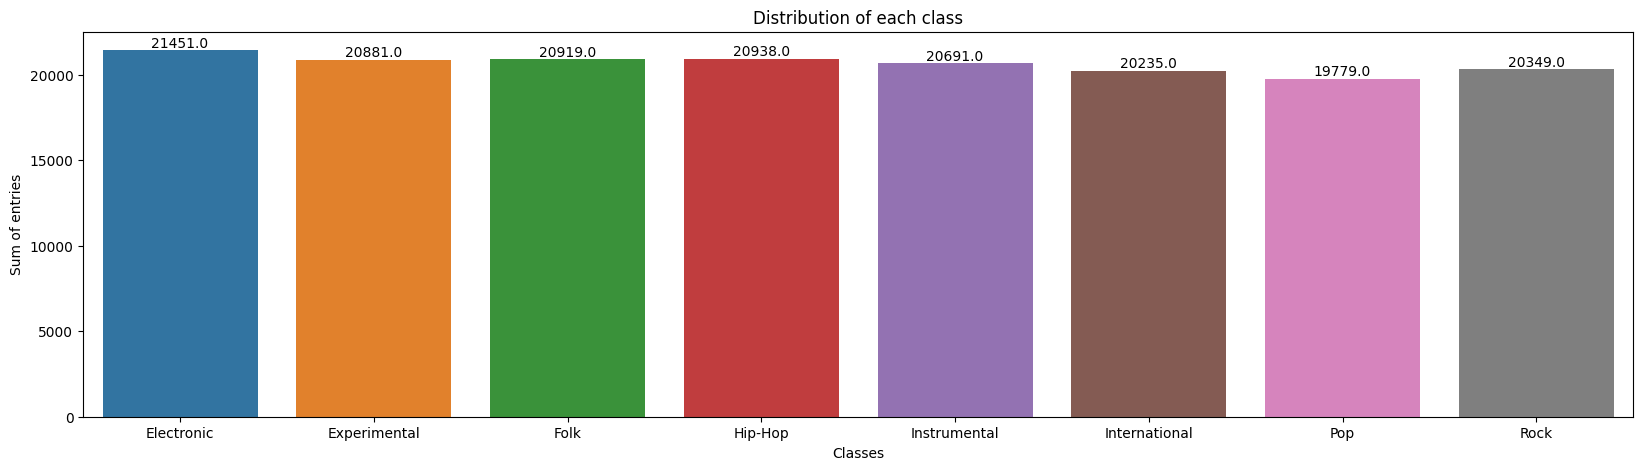

In [ ]:
# plot data frequency for the whole dataset
plt.figure(figsize=(20,5))
data = pd.DataFrame(data = {'class_name': all_classes_count.keys(), 'sum of entries': all_classes_count.values()})
data["sum of entries"] = data["sum of entries"].astype("int32")
ax = sns.barplot(data = data, x= "class_name", y="sum of entries")
ax.set(xlabel = "Classes", ylabel = "Sum of entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
plt.title(f"Distribution of each class")
plt.show()

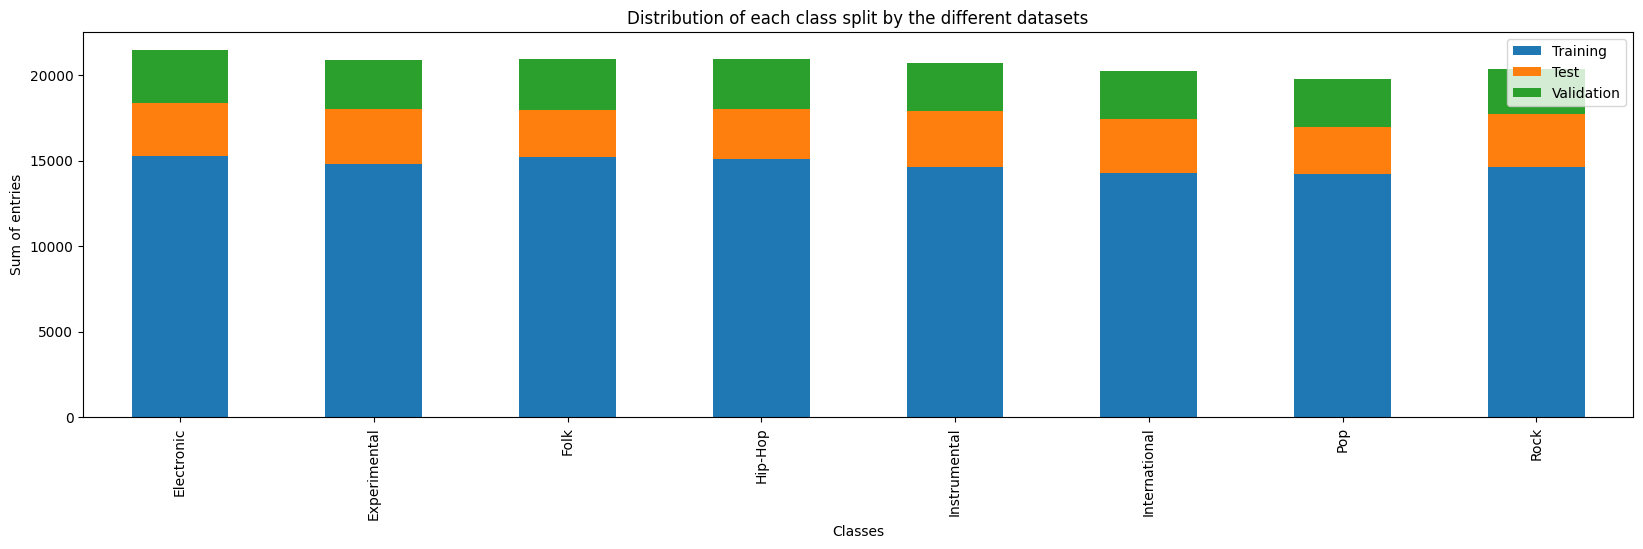

In [ ]:
# plot data frequency by set
df_counts_by_classes: pd.DataFrame = pd.DataFrame(dataset_number_of_occurences, index=CLASS_NAMES)
fig, axs = plt.subplots(figsize=(20,5))
axs.set_title(f"Distribution of each class split by the different datasets")
axs.set(xlabel = "Classes", ylabel = "Sum of entries")
df_counts_by_classes.plot(kind='bar', stacked=True, ax=axs)
fig.show()

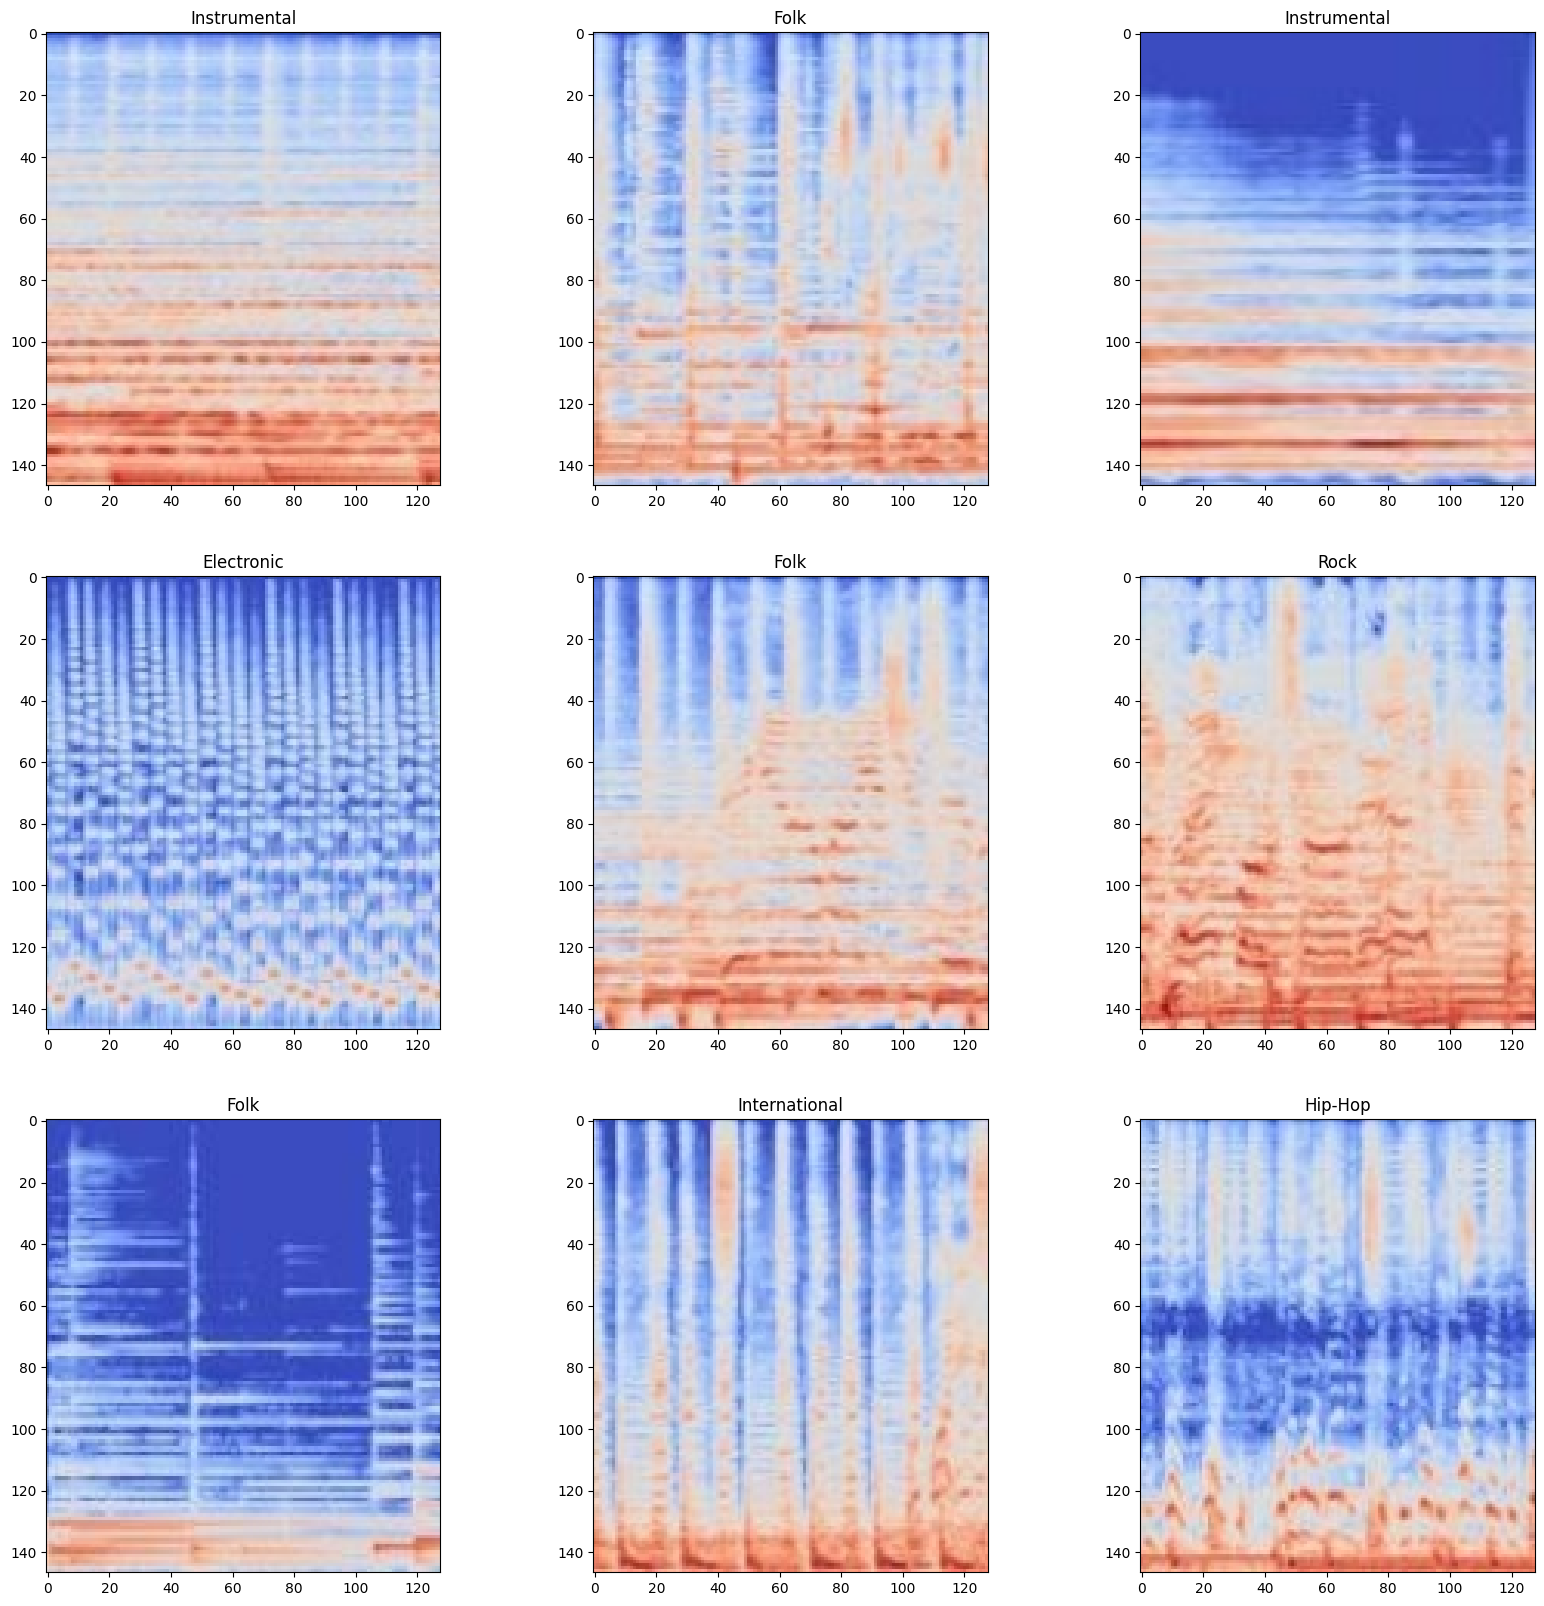

In [15]:
# plot first 9 items of the training dataset
plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
        plt.title(CLASS_NAMES[tf.argmax(labels[i])])
        # plt.axis("off")

# 2. Modeltraining

## 2.1 General setup

In [29]:
# Training parameter
EPOCHS = 50
EARLY_STOPPING_PATIENCE = EPOCHS//10
num_classes = len(CLASS_NAMES)

# setup early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(patience=EARLY_STOPPING_PATIENCE,
                                                  verbose=1,
                                                  restore_best_weights=True)

In [30]:
# define default input layer
def get_input_layer():
    input = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS))
    input_layer = tf.keras.layers.Rescaling(1./255)(input)
    return input, input_layer

input, input_layer = get_input_layer()

In [31]:
# define function to plot history for training and validation accuracy as well as loss
def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(len(acc))

  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

## 2.2 VGG 16 Model

In [ ]:
# function to create the vgg16 model from tensorflow optional with pre-trained weights
def create_vgg_16_base(weights: str, input_layer):
    base_model = tf.keras.applications.vgg16.VGG16(include_top=False,
                                      weights=weights,
                                      input_tensor=None,
                                      input_shape=(IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS),
                                      pooling=None)(input_layer)

    vgg16_model = tf.keras.layers.Flatten()(base_model)
    vgg16_model = tf.keras.layers.Dense(128, activation='relu')(vgg16_model)
    vgg16_model = tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')(vgg16_model)

    return vgg16_model

In [ ]:
# create a vgg 16 like model with data augmentation layer and pre-trained weights and display the summary
vgg_16_base_model_imagenet = create_vgg_16_base("imagenet", input_layer)
vgg_16_model_pre_trained = tf.keras.Model(inputs=input, outputs=vgg_16_base_model_imagenet)

# create optimizer with optimal learning rate --> weights already included --> smaller learning rate
optimizer_training_vgg_pre_trained = tf.keras.optimizers.Adam(learning_rate=1e-4)

vgg_16_model_pre_trained.compile(optimizer=optimizer_training_vgg_pre_trained,
                                 loss='categorical_crossentropy',
                                 metrics=['accuracy'])

vgg_16_model_pre_trained.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_3 (Dense)             (None, 128)               1048704   
                                                                 
 dense_4 (Dense)             (None, 8)                 1032      
                                                            

In [ ]:
# Train the model with data augmentation and early stopping
history_vgg_16_lr = vgg_16_model_pre_trained.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
    batch_size=BATCH_SIZE,
    callbacks=early_stopping
)

In [ ]:
vgg_16_model_pre_trained.evaluate(test_ds)

## 2.3 Genre Classification CNN

In [32]:
# function to create the vgg16 model from tensorflow optional with pre-trained weights
def create_base_genre_classification(dropout_term: int = 0.2, num_classes: int = 8):

    input = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS))
    input_layer = tf.keras.layers.Rescaling(1./255)(input)

    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(input_layer)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(dropout_term)(x)

    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(dropout_term)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(dropout_term)(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(dropout_term)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(dropout_term)(x)
    # x = BatchNormalization()(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(200, activation='relu')(x)
    x = tf.keras.layers.Dense(100, activation='relu')(x)
    output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(inputs=input, outputs=output_layer)

In [ ]:
# create a genre classification model display the summary
genre_classification_model = create_base_genre_classification(dropout_term = 0.1, num_classes=len(CLASS_NAMES))
# genre_classification_model = tf.keras.Model(inputs=input, outputs=genre_classification_layers)

# create optimizer with specific learning rate
optimizer_genre_classification = tf.keras.optimizers.Adam(learning_rate=1e-4)

genre_classification_model.compile(optimizer=optimizer_genre_classification,
                                 loss='categorical_crossentropy',
                                 metrics=['accuracy'])

genre_classification_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 147, 128, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 147, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 145, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 72, 63, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 72, 63, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 70, 61, 32)        4640      
                                                             

In [ ]:
# Train the model with data augmentation and early stopping
history_gcm = genre_classification_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
    batch_size=BATCH_SIZE,
    callbacks=early_stopping
)

Epoch 1/50
3691/3691 [==============================] - 128s 31ms/step - loss: 1.8401 - accuracy: 0.3012 - val_loss: 1.8589 - val_accuracy: 0.2957
Epoch 2/50
3691/3691 [==============================] - 101s 27ms/step - loss: 1.7191 - accuracy: 0.3608 - val_loss: 1.8088 - val_accuracy: 0.3261
Epoch 3/50
3691/3691 [==============================] - 98s 27ms/step - loss: 1.6567 - accuracy: 0.3900 - val_loss: 1.7251 - val_accuracy: 0.3636
Epoch 4/50
3691/3691 [==============================] - 96s 26ms/step - loss: 1.6052 - accuracy: 0.4173 - val_loss: 1.6445 - val_accuracy: 0.4010
Epoch 5/50
3691/3691 [==============================] - 99s 27ms/step - loss: 1.5560 - accuracy: 0.4398 - val_loss: 1.5924 - val_accuracy: 0.4249
Epoch 6/50
3691/3691 [==============================] - 94s 26ms/step - loss: 1.5131 - accuracy: 0.4575 - val_loss: 1.5947 - val_accuracy: 0.4274
Epoch 7/50
3691/3691 [==============================] - 98s 26ms/step - loss: 1.4748 - accuracy: 0.4715 - val_loss: 1.4721

In [ ]:
# evaluate genre classifier on test data
genre_classification_model.evaluate(test_ds)

759/759 [==============================] - 19s 24ms/step - loss: 1.8759 - accuracy: 0.4679


[1.8759421110153198, 0.46787744760513306]

In [ ]:
# save classification model to drive
genre_classification_model.save("drive/MyDrive/genreClassifikationCNN3SecondsAllSpectrograms")
genre_classification_model.save("drive/MyDrive/genreClassifikationCNNh53SecondsAllSpectrograms", save_format="h5")

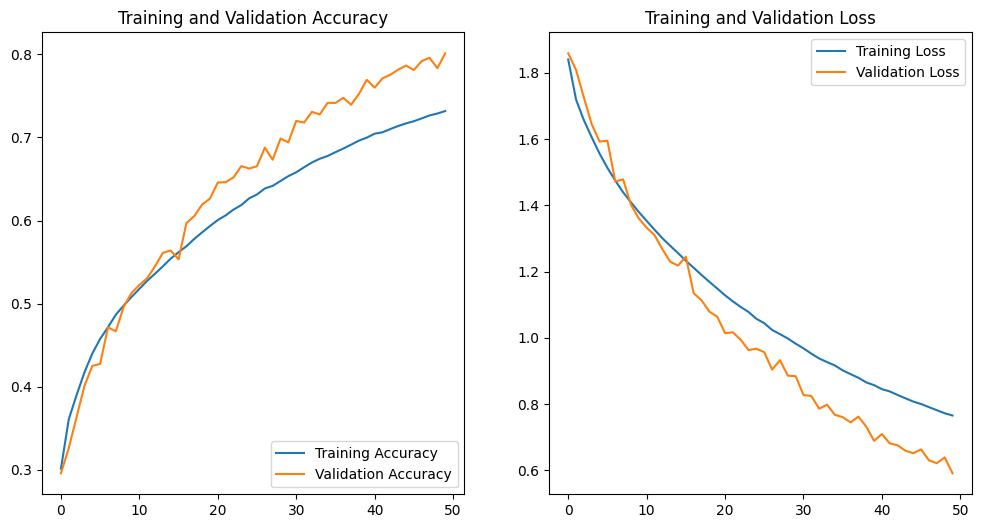

In [ ]:
# plot model history
plot_history(history_gcm)

## 2.4 Genre classification melspectrogram

In [43]:
# create a genre classification model display the summary
genre_classification_model = create_base_genre_classification(dropout_term = 0.0, num_classes=len(CLASS_NAMES))
# genre_classification_model = tf.keras.Model(inputs=input, outputs=genre_classification_layers)

# create optimizer with specific learning rate
optimizer_genre_classification = tf.keras.optimizers.Adam(learning_rate=1e-4)

genre_classification_model.compile(optimizer=optimizer_genre_classification,
                                 loss='categorical_crossentropy',
                                 metrics=['accuracy'])

genre_classification_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 147, 128, 3)]     0         
                                                                 
 rescaling_6 (Rescaling)     (None, 147, 128, 3)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 145, 126, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 72, 63, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 72, 63, 16)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 70, 61, 32)        4640      
                                                           

In [44]:
# Train the model with data augmentation and early stopping
history_gcm = genre_classification_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
    batch_size=BATCH_SIZE,
    callbacks=early_stopping
)

Epoch 1/50
722/722 [==============================] - 36s 47ms/step - loss: 1.9467 - accuracy: 0.2435 - val_loss: 1.8988 - val_accuracy: 0.2715
Epoch 2/50
722/722 [==============================] - 40s 55ms/step - loss: 1.8494 - accuracy: 0.2921 - val_loss: 1.8473 - val_accuracy: 0.3013
Epoch 3/50
722/722 [==============================] - 41s 56ms/step - loss: 1.8046 - accuracy: 0.3183 - val_loss: 1.8142 - val_accuracy: 0.3217
Epoch 4/50
722/722 [==============================] - 33s 45ms/step - loss: 1.7597 - accuracy: 0.3428 - val_loss: 1.7890 - val_accuracy: 0.3410
Epoch 5/50
722/722 [==============================] - 29s 40ms/step - loss: 1.7136 - accuracy: 0.3647 - val_loss: 1.7796 - val_accuracy: 0.3418
Epoch 6/50
722/722 [==============================] - 32s 44ms/step - loss: 1.6728 - accuracy: 0.3878 - val_loss: 1.7632 - val_accuracy: 0.3551
Epoch 7/50
722/722 [==============================] - 36s 50ms/step - loss: 1.6405 - accuracy: 0.4024 - val_loss: 1.7671 - val_accuracy:

In [45]:
# evaluate genre classifier on test data
genre_classification_model.evaluate(test_ds)

3244/3244 [==============================] - 70s 22ms/step - loss: 1.7456 - accuracy: 0.3869


[1.7455660104751587, 0.3868882358074188]

In [46]:
# save classification model to drive
genre_classification_model.save("drive/MyDrive/genreClassifikationCNN3SecondsAllSpectrograms")

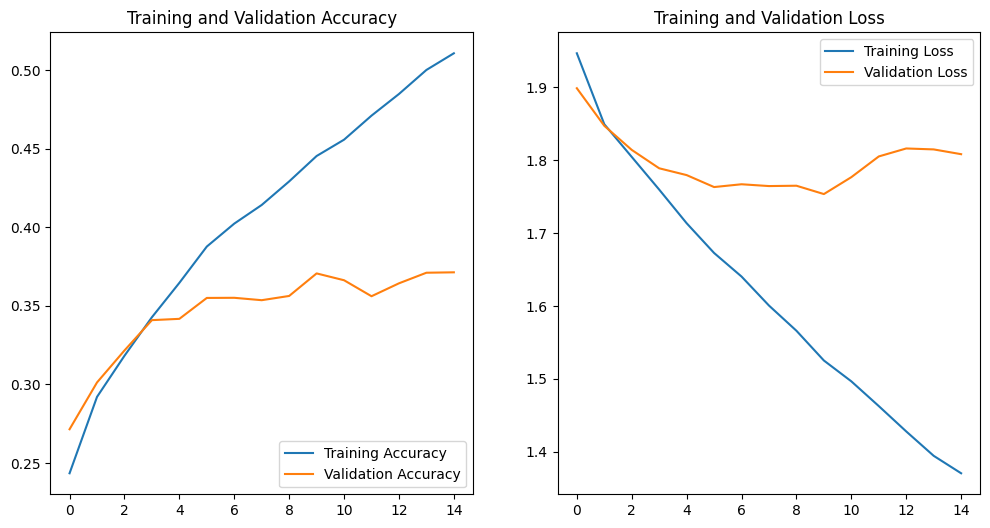

In [47]:
# plot model history
plot_history(history_gcm)